## In Cloud Management
This notebook is defining separate "clouds" from each flight of the ISLAS campaign. The notebook sets an in-cloud threshold based on total water content (TWC), but also looks at flight log information for defining when a "new" cloud is entered and when it is exited again. 


TODO: A time is set manually for each of these entries/exits and saved in a file.

TODO: define Top - Bulk - Base  heights for each cloud

Setting these entry/exit times and the TBB heights is done manually, and will be partially subjective.

In [1]:
# imports from packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from global_land_mask import globe # for checking if on land
import warnings
import cartopy.crs as ccrs
import cartopy.feature as creature
import os #get a list of all directories/files

# imports from files
import functions
import read_cdp
import read_cip_txt
import read_lwc
import read_nav
import read_cip_nc
import plots
import numb_conc
import in_cloud_detect
import read_flight_report

# surpress UserWarning connected to timezoneless np.datetime
warnings.filterwarnings("ignore", message="no explicit representation of timezones available for np.datetime64")

In [2]:
# --- Data import
# Based on scripts in files read_*.py

# Navigational data
# -- nav_df: data variables
# -- nav_stats_dict: statistics for each flight
nav_df, nav_stats_dict = read_nav.read_nav()

# CDP data
# -- cdp_bulk_df: Bulk variables per flight
# -- cdp_bins_df: Bin details (max, min size)
# -- cdp_var_df: Variable information (names, units)
# -- cdp_meta_df: Metadata/instrument settings
cdp_bulk_df, cdp_bins_df, cdp_var_df, cdp_meta_df = read_cdp.read_cdp(nav_df)

# CIP data txt file
#cip_binneddata_df, cip_bins_df, cip_var_df, cip_proc_dict = read_cip_txt.read_cip_txt()   # CIP:  conc per bin, from txt file

# CIP data nc file
# -- cip_bulk_calc_df: Bulk variables per flight
# -- cip_conc_df: Concentration per bin
# -- cip_varnc_df: Variable, longname and unit
cip_bulk_calc_df, cip_conc_df, cip_varnc_df = read_cip_nc.read_cip_nc()    # CIP calculated bulk information                                                                 #       variable information, processing information

# LWC data
# -- lwc_bulk_df: 
# -- lwc_meta_df:
# -- lwc_chan_dict:
#lwc_bulk_df, lwc_meta_df, lwc_chan_dict = read_lwc.read_lwc(nav_df)

# Flight report data:
# -- report_cloud_df: flight report information
# -- flights: list of flightnames
#report_cloud_df, flights = read_fligth_reports_all.read_fligth_reports_all()

----Reading CDP files:
Reading: ../2022-islas/as220014/microphy/pads/20220403071511/02CDP 20220403071511.csv
Reading: ../2022-islas/as220009/microphy/pads/20220326080106/02CDP 20220326080106.csv
Reading: ../2022-islas/as220010/microphy/pads/02CDP 20220326133751.csv
Reading: ../2022-islas/as220007/microphy/pads/20220324080247/02CDP 20220322105458.csv
Reading: ../2022-islas/as220015/microphy/pads/20220403123534/02CDP 20220403123534.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324080247/02CDP 20220324080247.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324113123/02CDP 20220324113123.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324130909/02CDP 20220324130909.csv
Reading: ../2022-islas/as220013/microphy/pads/20220331093304/02CDP 20220331093304.csv
Reading: ../2022-islas/as220011/microphy/pads/02CDP 20220329081432.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330135853/02CDP 20220330135853.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330134834/

In [3]:
# Flight management and flight log preparation

main_path = '../2022-islas/' # path to ISLAS data
drop_flights = ['as220005','as220006'] # flights to drop, (if not all are to be analyzed 5 and 6 are in France)

# getting flights
flights = [
    f for f in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, f))
]
flights = [i for i in flights if i not in drop_flights] # remove flights to drop using list comprehension

# create a dictionary of flight log file names for each flight
flight_rep_dict = {}
for flight in flights:
    flight_path = f'{main_path+flight}/CRvol' #filepath that holds the flight reports
    # get list of flight report files 
    files = [
        f for f in os.listdir(flight_path)
        if f.endswith('CRvol.csv') # only get the csv-versions of the files
    ]
    flight_rep_dict[flight] = files #store flight and list of files as key-value pair

#print(flight_rep_dict['as220014'])

In [4]:
# Checking variables
# cip_bulk_calc_df.columns

#report_cloud_df[report_cloud_df['flightid']=='as220009']
#nav_stats_dict
#report_cloud_df.sort_values(by = 'date')

In [5]:
# -- Join the relevant columns from the nav, the cip, and the cdp data
# select time and number concentration columns from cip and cdp
# sort by time to help joining
# CIP IWC, LWC etc have been calculated for particles >100 mum
cip_df = cip_bulk_calc_df[['time', 'NT (#/m3)','IWC (gram/m3)','LWC (gram/m3)']].sort_values(by='time', axis=0)
#cdp_df = cdp_bulk_df[['time', 'Number Conc corr (#/cm^3)', 'LWC corr (g/m^3)']].sort_values(by='time', axis=0)
cdp_df = cdp_bulk_df[['time', 'Number Conc corr (#/cm^3)', 'LWC corr (g/m^3)','MVD (um)','Number Conc (#/cm^3)', 'LWC (g/m^3)']].sort_values(by='time', axis=0)
# select temperature and flightid from nav
nav_sel_df = nav_df[['Latitude (degree)', 'Longitude (degree)','Altitude (meter)','Temperature (Celsius)','flightid']].sort_values(by='time', axis=0)

# join cip and cdp by time
meas_df = pd.merge_asof(cip_df, cdp_df, on = 'time', direction = 'nearest', suffixes=('_cip','_cdp'))
microphy_df = pd.merge_asof(meas_df, nav_sel_df, on = 'time', direction = 'nearest')
microphy_df['flightid']=microphy_df['flightid'].astype("category") # make sure that flight is of type "category")

In [6]:
# Checking variables
#microphy_df.time

In [7]:
# -- Find total number concentration by adding CIP and CDP
# adjust cip to equal units as cdp
microphy_df['CIP NT (#/cm3)'] = microphy_df['NT (#/m3)']*10**(-6)
# sum cip and cdp in #/cm3 to find total num conc
microphy_df['tot NT (#/cm3)'] = microphy_df['CIP NT (#/cm3)']+microphy_df['Number Conc corr (#/cm^3)']

### Choosing In-cloud values

Following the Korolev 22 paper: "In the present study the thresholds for liquid water content and ice water content (IWC) were set as LWC > 0.01 g m−3, IWC > 0.01 g m−3, respectively. The phase composition of clouds was identified based on the assessment of the ice water fraction mu = IWC∕(LWC + IWC). Thus, clouds with 𝜇=0.9 were considered as ice, clouds with 𝜇 =0.1 were defined as liquid, and clouds 0.1 ≤ 𝜇𝜇 ≤ 0.9 were determined as mixed-phase clouds."
Korolev 2003 paper uses  TWC>0.01g m-3 as in-cloud threshold. To summarize: we only need one threshold

To get more distinct edges of the cloud, a moving average of TWC should be calculated to "skip" any spikes in TWC not related to a larger cloud mass.

In [8]:
# --- TWC - Total Water Content
# estimate total water content from cdp as liquid and all from CIP as ice (use LWC from cdp and IWC from CIP)
microphy_df['TWC (gram/m3)'] = microphy_df['LWC corr (g/m^3)'] + microphy_df['IWC (gram/m3)']

# calculate the rolling mean of TWC over X timesteps
# I am interested in 2 min legs of the cloud: each timestep is 5 sec -> rolling window of 24 will be 2 min
# rolling mean also calculated for LWC and Temperature
microphy_df['TWC_RM'] = microphy_df['TWC (gram/m3)'].rolling(window=24, center = True).mean()
microphy_df['LWC_RM'] = microphy_df['LWC corr (g/m^3)'].rolling(window=24, center = True).mean()
microphy_df['T_RM'] = microphy_df['Temperature (Celsius)'].rolling(window=24, center = True).mean()

# in-cloud threshold for TWC
in_cl_th = 0.01

# Test plotting
# microphy_df['TWC (gram/m3)'].plot()
# microphy_df['TWC_RM'].plot()

### Flightlog information and testing for choosing in cloud values

#### Flightid as220015
Notes from Flight report:
12\:57\: entry cloud top
1305: cloud bottom
1319: exit cloud top
1339: cloud top entry
1342:
1346: cloud top level


In [9]:
# work only only one file for now
flight = 'as220015'

# get the calculated data from the flight
sel_df = microphy_df[microphy_df['flightid']==flight] 

# getting flight report data from
f_list = flight_rep_dict[flight]

# read one file from flight report list
file = f'{main_path}{flight}/CRvol/{f_list[1]}'
test = read_flight_report.read_flight_report(file)

test['date'] = pd.to_datetime(test['date']) #make sure "date" is datetime


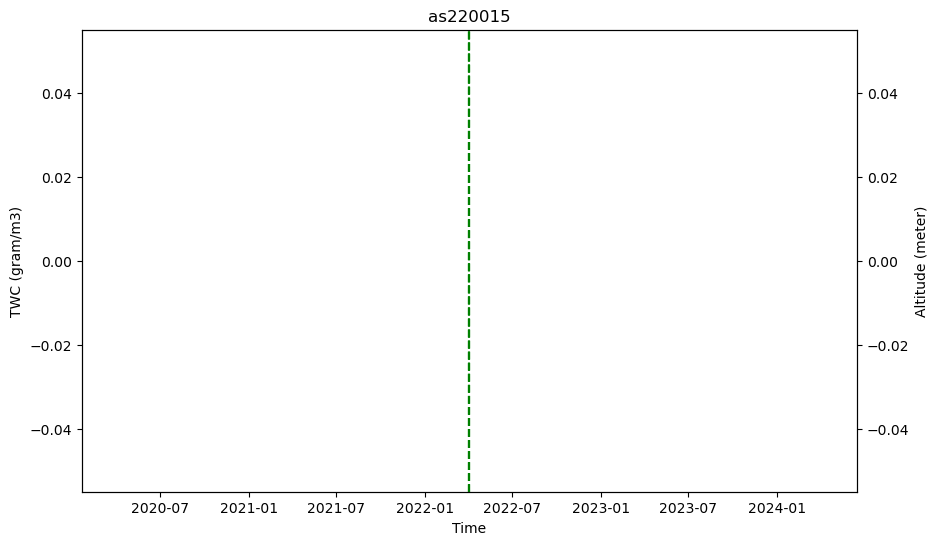

In [10]:
# Make a plot of TWC vs time
fig, ax1 = plt.subplots(nrows = 1, ncols=1, figsize=(10,6))

# plot Total Water Content
ax1.plot(sel_df['time'], sel_df['TWC (gram/m3)'])
ax1.set_ylabel('TWC (gram/m3)')
ax1.set_xlabel('Time')
ax1.set_title(flight)

ax2 = ax1.twinx()

# Plot altitude of fligth
ax2.plot(sel_df['time'], sel_df['Altitude (meter)'], 'r')
ax2.set_ylabel('Altitude (meter)')

test = pd.to_datetime([
    '2022-04-03T12:58:00Z',
    '2022-04-03T13:19:00Z',
    '2022-04-03T13:39:00Z',
    '2022-04-03T14:57:00Z'

])

# Mark in-cloud values by looping over the rep_df and plotting all lines with cloud in/cloud out.
for t in test:
    plt.axvline(x=t, color='g', linestyle='--')

# core for spanning area
#plt.axvline(x=pd.to_datetime(), color='g', linestyle='--')


#plt.legend()
#plt.savefig('X.png')
plt.show()

#### Flightid as220014
Notes from Flight reports:


In [11]:
flight = 'as220014'

# get the calculated data from the flight
sel_df = microphy_df[microphy_df['flightid']==flight] 

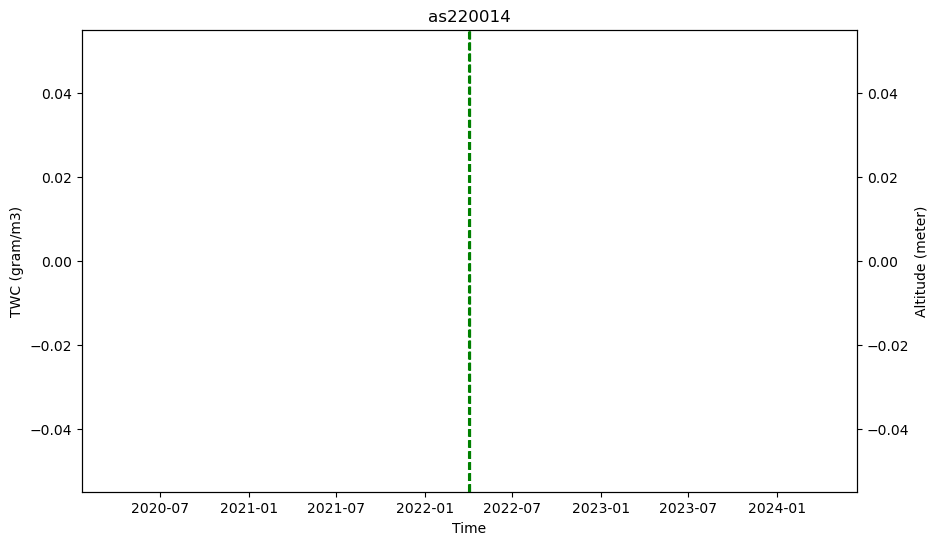

In [12]:
# Make a plot of TWC vs time
fig, ax1 = plt.subplots(nrows = 1, ncols=1, figsize=(10,6))

# plot Total Water Content
ax1.plot(sel_df['time'], sel_df['TWC (gram/m3)'])
ax1.set_ylabel('TWC (gram/m3)')
ax1.set_xlabel('Time')
ax1.set_title(flight)

ax2 = ax1.twinx()

# Plot altitude of fligth
ax2.plot(sel_df['time'], sel_df['Altitude (meter)'], 'r')
ax2.set_ylabel('Altitude (meter)')

test = pd.to_datetime([
    '2022-04-03T07:16:00Z',
    '2022-04-03T13:19:00Z',
    '2022-04-03T13:39:00Z',
    '2022-04-03T14:57:00Z'

])


# Mark in-cloud values by looping over the rep_df and plotting all lines with cloud in/cloud out.
for t in test:
    plt.axvline(x=t, color='g', linestyle='--')


#plt.legend()
#plt.savefig('X.png')
plt.show()

In [13]:
# Plot location for flight, plotting via predefined function

# functions.plot_flight_v_data(flight, nav_stats_dict, microphy_df)
functions.plot_flight_v_data(flight, nav_stats_dict, microphy_df, variable='Number Conc corr (#/cm^3)', save_f='test.png')

TypeError: plot_flight_v_data() got multiple values for argument 'variable'

## super cooled liquid fraction

From komurcu 2014: SLF = r(liquid water)/(r(liquid water) + r(ice))
where r= mixing ration in kg/kg

I have LWC from cdp and iwc from cip instead: 

In [14]:
# Old version (before calculating rolling mean
# -- Calculate SLF (supercooled liquid fraction)

# masking all values of TWC lower than in cloud threshold
microphy_df['TWC (gram/m3)'] = microphy_df['TWC (gram/m3)'].mask(microphy_df['TWC (gram/m3)'] < in_cl_th)

# also mask cloud parameters for same time step
microphy_df['LWC corr (g/m^3)'] = microphy_df['LWC corr (g/m^3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))
microphy_df['IWC (gram/m3)'] = microphy_df['IWC (gram/m3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))
microphy_df['tot NT (#/cm3)'] = microphy_df['tot NT (#/cm3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))

# calculate SLF by dividing LWC with TWC
microphy_df['SLF']= microphy_df['LWC corr (g/m^3)']/microphy_df['TWC (gram/m3)']*100

# categorize cloud phase
# set up categories for phase determination
# list of conditions to select categories
SLF_conds = [
    (microphy_df['SLF'] <= 0.1),
    (microphy_df['SLF'] >= 0.9),
    (microphy_df['SLF'] > 0.1) & (microphy_df['SLF'] < 0.9)
]
# list of categories to return
phase = [
    'ice',
    'liquid',
    'mixed-phase'
]
microphy_df['cloud_phase']=np.select(SLF_conds,phase,"ERROR")

In [15]:
# New version - with rolling mean of TWC
# -- Calculate SLF (supercooled liquid fraction)

# masking all values of TWC lower than in cloud threshold
microphy_df['TWC_RM'] = microphy_df['TWC_RM'].mask(microphy_df['TWC_RM'] < in_cl_th)

# also mask cloud parameters for same time step (Are these needed?)
microphy_df['LWC_RM'] = microphy_df['LWC_RM'].mask(np.isnan(microphy_df['TWC_RM']))
microphy_df['IWC (gram/m3)'] = microphy_df['IWC (gram/m3)'].mask(np.isnan(microphy_df['TWC_RM'])) 
microphy_df['tot NT (#/cm3)'] = microphy_df['tot NT (#/cm3)'].mask(np.isnan(microphy_df['TWC_RM']))

# calculate SLF by dividing LWC with TWC
microphy_df['SLF']= microphy_df['LWC_RM']/microphy_df['TWC_RM']*100

# categorize cloud phase
# set up categories for phase determination
# list of conditions to select categories
SLF_conds = [
    (microphy_df['SLF'] <= 0.1),
    (microphy_df['SLF'] >= 0.9),
    (microphy_df['SLF'] > 0.1) & (microphy_df['SLF'] < 0.9)
]
# list of categories to return
phase = [
    'ice',
    'liquid',
    'mixed-phase'
]
microphy_df['cloud_phase']=np.select(SLF_conds,phase,"ERROR")

In [16]:
microphy_df[microphy_df['SLF'].notnull()]

,time,NT (#/m3),IWC (gram/m3),LWC (gram/m3),Number Conc corr (#/cm^3),LWC corr (g/m^3),MVD (um),Number Conc (#/cm^3),LWC (g/m^3),Latitude (degree),...,Temperature (Celsius),flightid,CIP NT (#/cm3),tot NT (#/cm3),TWC (gram/m3),TWC_RM,LWC_RM,T_RM,SLF,cloud_phase
22,2022-03-22 11:39:11,347.736053,NaN,0.037691,0.000000,NaN,0.000000,0.000000,0.000000,70.213264,...,-19.249907,IS22-02,0.000348,NaN,NaN,0.010377,7.683251e-07,-19.239073,0.007404,ice
23,2022-03-22 11:39:16,1151.207397,0.010374,0.072620,0.000000,0.000000,0.000000,0.000000,0.000000,70.218002,...,-19.231142,IS22-02,0.001151,0.001151,0.010374,0.011962,7.802956e-07,-19.225430,0.006523,ice
24,2022-03-22 11:39:21,1374.571655,0.010008,0.098470,0.000000,0.000000,0.000000,0.000000,0.000000,70.222763,...,-19.029806,IS22-02,0.001375,0.001375,0.010008,0.013224,7.802956e-07,-19.212842,0.005901,ice
25,2022-03-22 11:39:26,1673.645142,0.028117,0.379803,0.071181,0.000002,4.414266,0.074349,0.000002,70.227554,...,-18.977892,IS22-02,0.001674,0.072854,0.028119,0.014165,7.922523e-07,-19.199568,0.005593,ice
26,2022-03-22 11:39:31,1500.915527,0.015472,0.151529,0.000000,0.000000,0.000000,0.000000,0.000000,70.232368,...,-18.941507,IS22-02,0.001501,0.001501,0.015472,0.014697,7.922523e-07,-19.179503,0.005391,ice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26215,2022-04-03 16:11:54,3073.903320,0.013094,0.066524,0.032588,0.000033,12.500000,0.037175,0.000038,69.592621,...,-45.526077,IS22-11,0.003074,0.035662,0.013127,0.012926,1.567372e-04,-45.504502,1.212542,liquid
26216,2022-04-03 16:11:59,3271.852295,0.011767,0.054416,0.000000,0.000000,0.000000,0.000000,0.000000,69.586632,...,-45.497318,IS22-11,0.003272,0.003272,0.011767,0.012888,1.567372e-04,-45.502732,1.216171,liquid
26217,2022-04-03 16:12:04,2968.744385,NaN,0.036256,0.000000,NaN,0.000000,0.000000,0.000000,69.580650,...,-45.571278,IS22-11,0.002969,NaN,NaN,0.012398,1.567372e-04,-45.496845,1.264257,liquid
26218,2022-04-03 16:12:09,4039.629150,0.011125,0.040154,0.000000,0.000000,0.000000,0.000000,0.000000,69.574669,...,-45.560314,IS22-11,0.004040,0.004040,0.011125,0.011345,1.567372e-04,-45.493508,1.381548,liquid


## Surface categorization

In [17]:
# -- categorize surface condition based on coordinates: Mainland, Svalbard, Ocean, Ice
# code based on medium article: https://medium.com/@michalwesleymnach/the-complete-guide-to-create-columns-based-on-multiple-conditions-in-pandas-dataframes-eedf2c0392a6
# columns and thresholds needed for the selection of categories
sv_s = 76 # southmost point of Svalbard
lat = microphy_df['Latitude (degree)']
lon = microphy_df['Longitude (degree)']
ice_box = (73,15,76,22) #simple bounding box with lat_min, lon_min, lat_max, lon_max

# list of conditions to select categories
conds = [
    globe.is_land(lat,lon), #& (lat < sv_s),
   # globe.is_land(lat,lon) & (lat > sv_s),
    globe.is_ocean(lat,lon) & ((lat < ice_box[0]) | (lat > ice_box[2]) | (lon < ice_box[1]) | (lon > ice_box[3])),
    globe.is_ocean(lat,lon) & ((lat >= ice_box[0]) & (lat <= ice_box[2]) & (lon >= ice_box[1]) & (lon <= ice_box[3]))
]
# list of categories to return
cats = [
    'land-main',
    #'land-svalbard',
    'sea-ocean',
    'sea-ice'
]
# create a new column from the conditions
microphy_df['surf_cond']=np.select(conds,cats,"ERROR")

In [18]:
# -- Temperature bin adjustment
# set min, max and interval for temperature bins
t_int = 2 # the interval I want my bins to be in

# --- temperature bins based on max and min values
# I want my bins to span all the temperatures in my data, bins set from 0 and outward in either direction
# -- find max and min temperatures in dataset
#t_max = nav_df['Temperature (Celsius)'].max()
#t_min = nav_df['Temperature (Celsius)'].min()
# set max and min for bins based on these, based on closest integer dividable by the interval
#tb_min = t_min - t_min%t_int
#tb_max = t_max - t_max%t_int + 2*t_int # two intervall added to get the closest integer higher than the dataset max
                                   # and adjust for arange use of bounds
# ----------
# --- temperature bins set on interesting range
tb_min = -40
tb_max = 0
# --------

b_range = np.arange(tb_min, tb_max, t_int) # create bin range
b_labels = np.arange((tb_min+t_int), tb_max, t_int) # create bin labels, use higher bounds
#b_labels = np.arange(tb_min, tb_max-t_int, t_int) # create bin labels, use lower bounds

# add new column to microphy dataframe with temperature category
microphy_df['temp_cat'] = pd.cut(microphy_df['Temperature (Celsius)'], bins=b_range, labels=b_labels)


In [19]:
b_range

array([-40, -38, -36, -34, -32, -30, -28, -26, -24, -22, -20, -18, -16,
       -14, -12, -10,  -8,  -6,  -4,  -2])

In [20]:
# --- median values per category for the given temperature categories
# calculate the median of variables per temperature category and store in dictionary

ref_df = pd.DataFrame({'temp_cat': list(b_labels)}) #create empty reference dataset (to get NaN where no values)

# Calculate median per temp category for each FLIGHT, store in dict
nc_stat_dict = {}  # empty dictionary for storing

for flight in flights:
    #calculate median per temperature category
    nc_temp_stat = microphy_df[microphy_df['flightid']==flight].groupby(['temp_cat'], observed=True)['tot NT (#/cm3)'].median()
    slf_temp_stat = microphy_df[microphy_df['flightid']==flight].groupby(['temp_cat'], observed=True)['SLF'].median()
    # combine ref_df with calculated, gives NaN on temp categories not present in flight
    resultat = pd.merge(ref_df, nc_temp_stat, on='temp_cat', how='left')
    resultat = pd.merge(resultat, slf_temp_stat, on='temp_cat', how='left')
    nc_stat_dict.update({flight: resultat}) # add to dictionary

# Calculate median per temp category for each SURFACE CATEGORY, store in dict
surf_stat_dict = {}  # empty dictionary for storing

#the surface type categories are defined in cats
for surf_type in cats:
    #calculate median per temperature category
    nc_temp_stat = microphy_df[microphy_df['surf_cond']==surf_type].groupby(['temp_cat'], observed=True)['tot NT (#/cm3)'].median()
    slf_temp_stat = microphy_df[microphy_df['surf_cond']==surf_type].groupby(['temp_cat'], observed=True)['SLF'].median()
    # combine ref_df with calculated, gives NaN on temp categories not present in surface category
    resultat = pd.merge(ref_df, nc_temp_stat, on='temp_cat', how='left')
    resultat = pd.merge(resultat, slf_temp_stat, on='temp_cat', how='left')
    surf_stat_dict.update({surf_type: resultat}) # add to dictionary

# calculate median for all flights and add to both dictionaries
nc_temp_stat = microphy_df.groupby(['temp_cat'], observed=True)['tot NT (#/cm3)'].median()
slf_temp_stat = microphy_df.groupby(['temp_cat'], observed=True)['SLF'].median()
# combine ref_df with calculated, gives NaN on temp categories not present in surface category
resultat = pd.merge(ref_df, nc_temp_stat, on='temp_cat', how='left')
resultat = pd.merge(resultat, slf_temp_stat, on='temp_cat', how='left')

nc_stat_dict.update({'All_flights': resultat}) # add to dictionary
surf_stat_dict.update({'All surfaces': resultat}) # add to dictionary

## Plots

In [21]:
microphy_df.columns

Index(['time', 'NT (#/m3)', 'IWC (gram/m3)', 'LWC (gram/m3)',
       'Number Conc corr (#/cm^3)', 'LWC corr (g/m^3)', 'MVD (um)',
       'Number Conc (#/cm^3)', 'LWC (g/m^3)', 'Latitude (degree)',
       'Longitude (degree)', 'Altitude (meter)', 'Temperature (Celsius)',
       'flightid', 'CIP NT (#/cm3)', 'tot NT (#/cm3)', 'TWC (gram/m3)',
       'TWC_RM', 'LWC_RM', 'T_RM', 'SLF', 'cloud_phase', 'surf_cond',
       'temp_cat'],
      dtype='object')

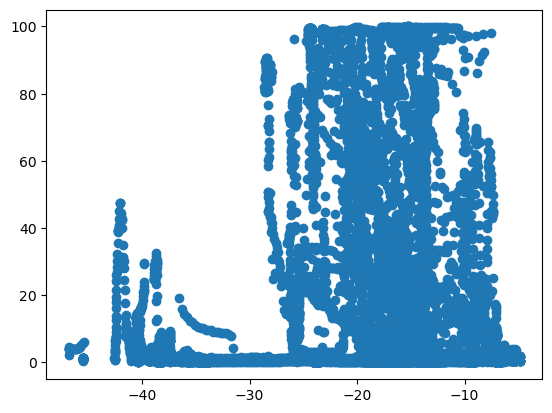

In [22]:
# scatterplot of 

plt.scatter(microphy_df['T_RM'], microphy_df['SLF'])

In [23]:
# create your own colormap, Single color
from matplotlib.colors import ListedColormap

# create custom colormaps
N = 256
# color name="Celeste" hex="c5fffd" r="197" g="255" b="253" 
celeste = np.ones((N, 4))
celeste[:, 0] = np.linspace(255/256, 1, N) # R = 197
celeste[:, 1] = np.linspace(232/256, 1, N) # G = 255
celeste[:, 2] = np.linspace(11/256, 1, N)  # B = 253
celeste_cmp = ListedColormap(celeste)

# color name="Non Photo blue" hex="88d9e6" r="136" g="217" b="230"
non_photo_blue = np.ones((N, 4))
non_photo_blue[:, 0] = np.linspace(255/256, 1, N) # R = 136
non_photo_blue[:, 1] = np.linspace(232/256, 1, N) # G = 217
non_photo_blue[:, 2] = np.linspace(11/256, 1, N)  # B = 230
non_photo_blue_cmp = ListedColormap(non_photo_blue)

# color name="Cool gray" hex="8b8bae" r="139" g="139" b="174"
cool_gray = np.ones((N, 4))
cool_gray[:, 0] = np.linspace(255/256, 1, N) # R = 139
cool_gray[:, 1] = np.linspace(232/256, 1, N) # G = 139
cool_gray[:, 2] = np.linspace(11/256, 1, N)  # B = 174
cool_gray_cmp = ListedColormap(cool_gray)

# color name="Feldgrau" hex="526760" r="82" g="103" b="96"
feldgrau = np.ones((N, 4))
feldgrau[:, 0] = np.linspace(255/256, 1, N) # R = 82
feldgrau[:, 1] = np.linspace(232/256, 1, N) # G = 103
feldgrau[:, 2] = np.linspace(11/256, 1, N)  # B = 96
feldgrau_cmp = ListedColormap(feldgrau)

# color name="Dark slate gray" hex="374b4a" r="55" g="75" b="74"
dark_slate_grey = np.ones((N, 4))
dark_slate_grey[:, 0] = np.linspace(255/256, 1, N) # R = 55
dark_slate_grey[:, 1] = np.linspace(232/256, 1, N) # G = 75
dark_slate_grey[:, 2] = np.linspace(11/256, 1, N)  # B = 74
dark_slate_grey_cmp = ListedColormap(dark_slate_grey)


#NB! check how to add this to plots!!


In [24]:
microphy_df.columns

Index(['time', 'NT (#/m3)', 'IWC (gram/m3)', 'LWC (gram/m3)',
       'Number Conc corr (#/cm^3)', 'LWC corr (g/m^3)', 'MVD (um)',
       'Number Conc (#/cm^3)', 'LWC (g/m^3)', 'Latitude (degree)',
       'Longitude (degree)', 'Altitude (meter)', 'Temperature (Celsius)',
       'flightid', 'CIP NT (#/cm3)', 'tot NT (#/cm3)', 'TWC (gram/m3)',
       'TWC_RM', 'LWC_RM', 'T_RM', 'SLF', 'cloud_phase', 'surf_cond',
       'temp_cat'],
      dtype='object')

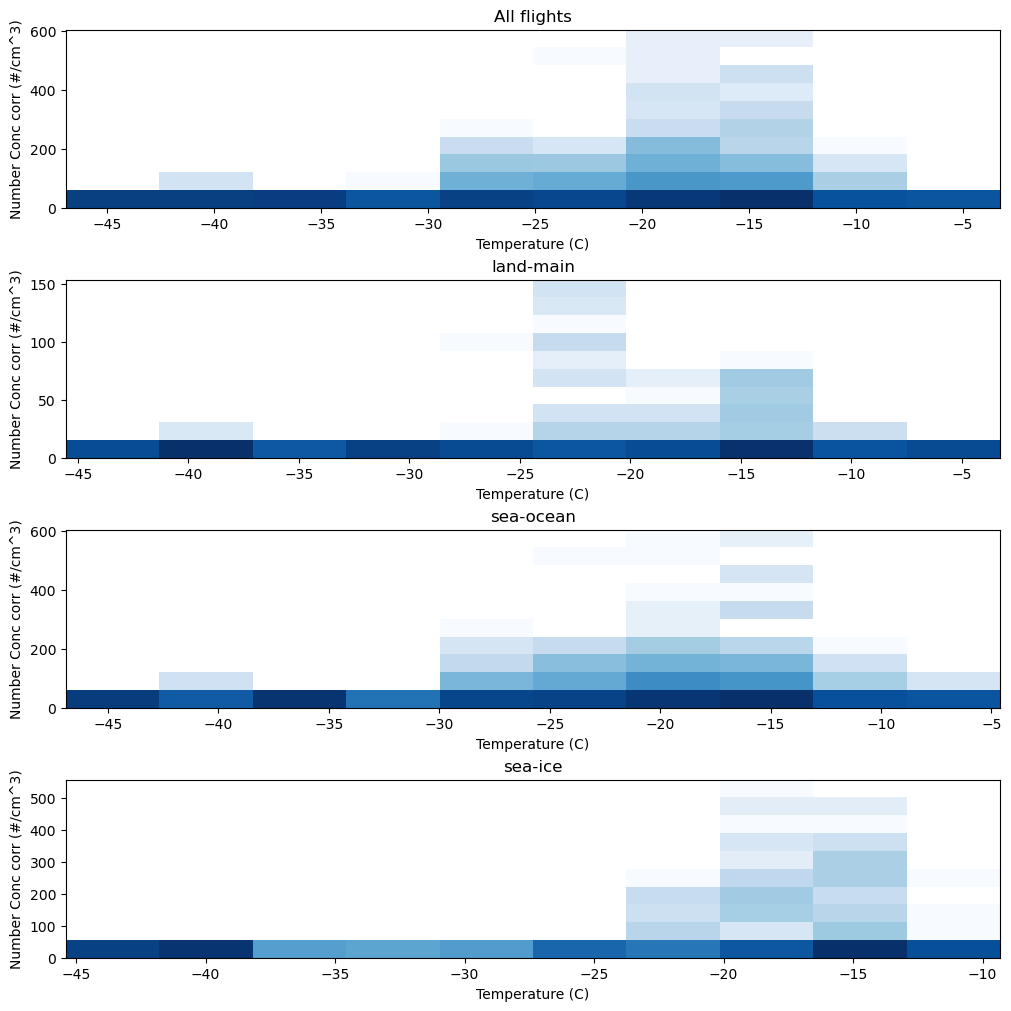

In [25]:
#-- 2D histplot testing
import matplotlib as mpl

fig, ax = plt.subplots(nrows = 4, ncols=1, figsize=(10,10), constrained_layout = True)

ax[0].hist2d(microphy_df['Temperature (Celsius)'], microphy_df['Number Conc corr (#/cm^3)'], 
             norm=mpl.colors.LogNorm(), cmap=plt.cm.Blues)
ax[0].set_ylabel('Number Conc corr (#/cm^3)')
ax[0].set_xlabel('Temperature (C)')
ax[0].set_title('All flights')

for count, surf_type in enumerate(cats):
    # Create similar plots for each of the surface types
    plot_df = microphy_df[microphy_df['surf_cond']==surf_type]
    row_n = count+1
    ax[row_n].hist2d(plot_df['Temperature (Celsius)'], plot_df['Number Conc corr (#/cm^3)'], 
                     norm=mpl.colors.LogNorm(), cmap=plt.cm.Blues)
    ax[row_n].set_ylabel('Number Conc corr (#/cm^3)')
    ax[row_n].set_xlabel('Temperature (C)')
    ax[row_n].set_title(surf_type)


plt.savefig('SLF_2Dhist.png')
plt.show()

In [26]:
microphy_df.columns

Index(['time', 'NT (#/m3)', 'IWC (gram/m3)', 'LWC (gram/m3)',
       'Number Conc corr (#/cm^3)', 'LWC corr (g/m^3)', 'MVD (um)',
       'Number Conc (#/cm^3)', 'LWC (g/m^3)', 'Latitude (degree)',
       'Longitude (degree)', 'Altitude (meter)', 'Temperature (Celsius)',
       'flightid', 'CIP NT (#/cm3)', 'tot NT (#/cm3)', 'TWC (gram/m3)',
       'TWC_RM', 'LWC_RM', 'T_RM', 'SLF', 'cloud_phase', 'surf_cond',
       'temp_cat'],
      dtype='object')

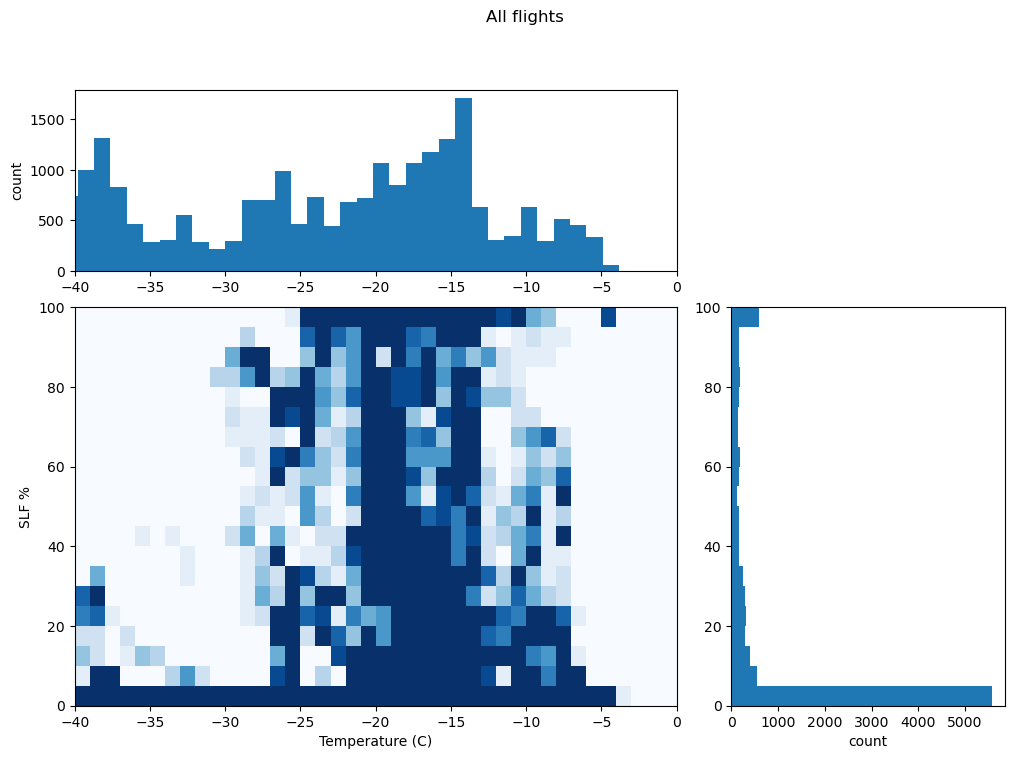

In [27]:
# testing marginal plot with matplotlib only

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
ax_main.hist2d(microphy_df['Temperature (Celsius)'], microphy_df['SLF'], 
             bins=(40, 20), range=[[-40,0],[0,100]],
             cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_main.set_ylabel('SLF %')
ax_main.set_xlabel('Temperature (C)')


ax_xDist.hist(microphy_df['Temperature (Celsius)'],bins=40, align='left')
ax_xDist.set(ylabel='count')

ax_yDist.hist(microphy_df['SLF'],bins=20,orientation='horizontal')
ax_yDist.set(xlabel='count')

fig.suptitle('All flights')
plt.savefig('test_marginal_all_fligths.png')
plt.show()

<>:33: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:41: SyntaxWarning: invalid escape sequence '\c'
<>:45: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:41: SyntaxWarning: invalid escape sequence '\c'
<>:45: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_16019/2230123011.py:33: SyntaxWarning: invalid escape sequence '\c'
  fig = slf_marg_plot(microphy_df, 'SLF per 2$^\circ$C temperature bins over all surfaces')
/tmp/ipykernel_16019/2230123011.py:37: SyntaxWarning: invalid escape sequence '\c'
  fig = slf_marg_plot(microphy_df[microphy_df['surf_cond']=='land-main'], 'SLF per 2$^\circ$C temperature bins over land')
/tmp/ipykernel_16019/2230123011.py:41: SyntaxWarning: invalid escape sequence '\c'
  fig = slf_marg_plot(microphy_df[microphy_df['surf_cond']=='sea-ocean'], 'SLF per 2$^\circ$C temperature bins over open ocean')

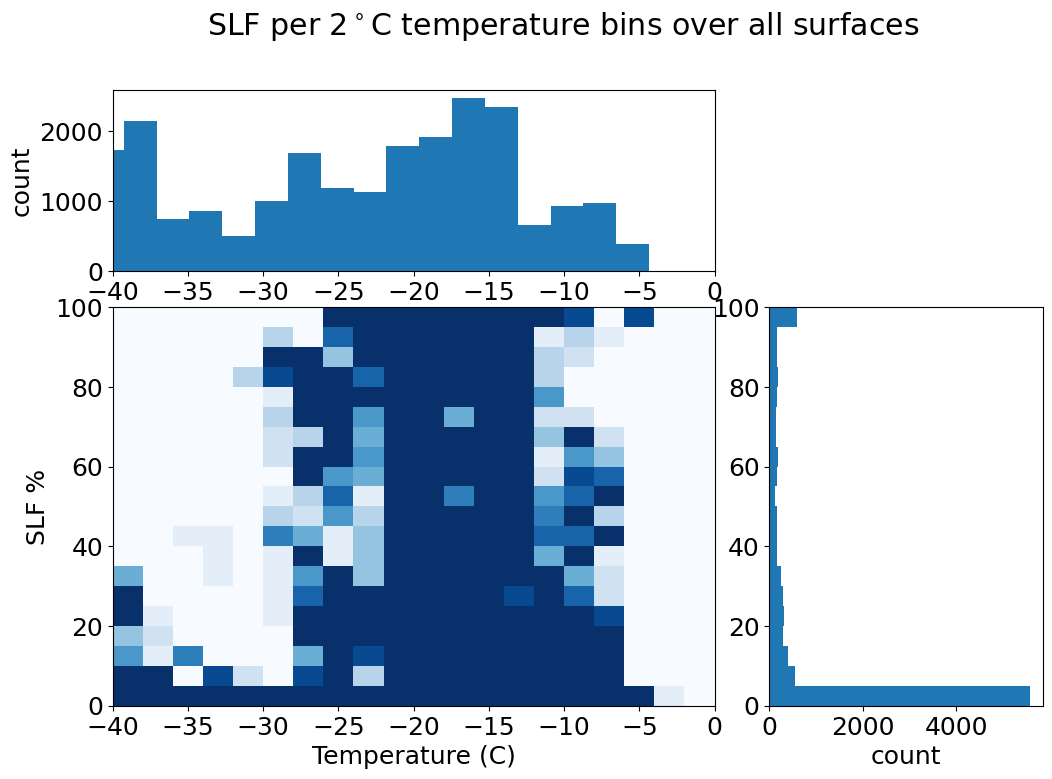

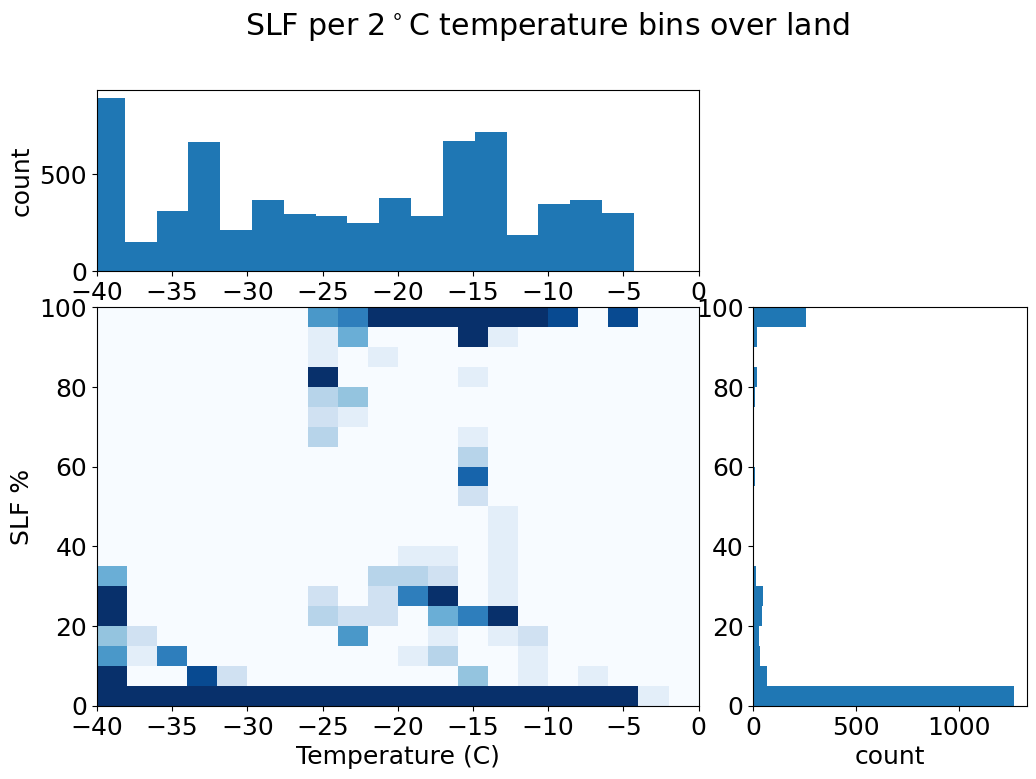

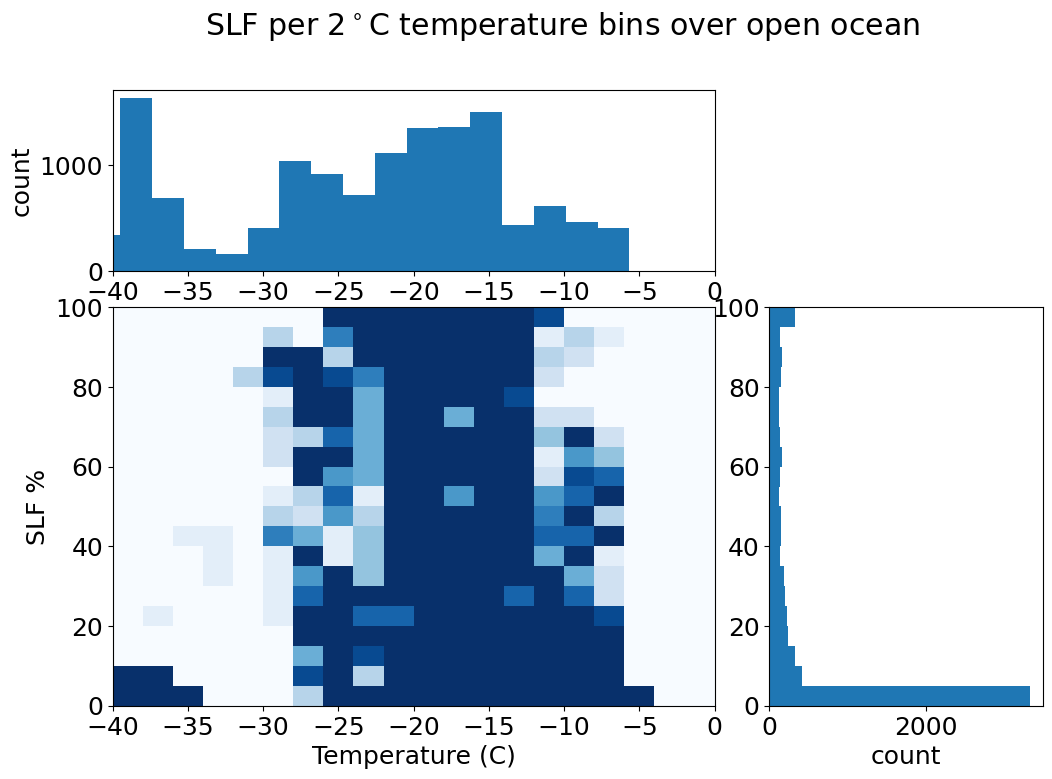

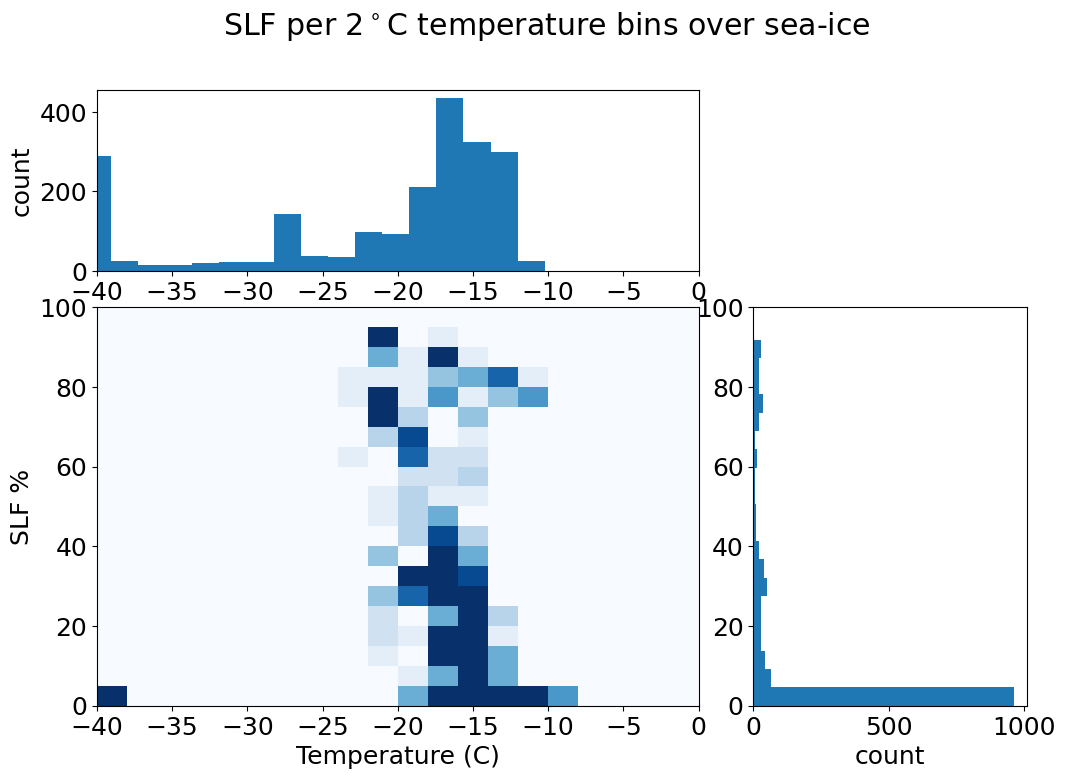

In [28]:
# SLF marginal plot for all surfaces, separately and total

def slf_marg_plot(df, title):
    import matplotlib.gridspec as gridspec
    
    fig = plt.figure(figsize=(12,8))

    plt.rcParams['font.size'] = 18
    
    gs = gridspec.GridSpec(3, 3)
    ax_main = plt.subplot(gs[1:3, :2])
    ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
        
    ax_main.hist2d(df['Temperature (Celsius)'], df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
    ax_main.set_ylabel('SLF %')
    ax_main.set_xlabel('Temperature (C)')
    
    
    ax_xDist.hist(df['Temperature (Celsius)'],bins=20, align='left')
    ax_xDist.set(ylabel='count')
    
    ax_yDist.hist(df['SLF'],bins=20,orientation='horizontal')
    ax_yDist.set(xlabel='count')
    
    fig.suptitle(title, fontsize = 'large')
    plt.show()
    return(fig)

# plot for all surfaces
fig = slf_marg_plot(microphy_df, 'SLF per 2$^\circ$C temperature bins over all surfaces')
fig.savefig('slf_margplot_all_flights.png')

# plot for land
fig = slf_marg_plot(microphy_df[microphy_df['surf_cond']=='land-main'], 'SLF per 2$^\circ$C temperature bins over land')
fig.savefig('slf_margplot_land.png')

# plot for ocean
fig = slf_marg_plot(microphy_df[microphy_df['surf_cond']=='sea-ocean'], 'SLF per 2$^\circ$C temperature bins over open ocean')
fig.savefig('slf_margplot_ocean.png')

# plot for sea-ice
fig = slf_marg_plot(microphy_df[microphy_df['surf_cond']=='sea-ice'], 'SLF per 2$^\circ$C temperature bins over sea-ice')
fig.savefig('slf_margplot_sea_ice.png')



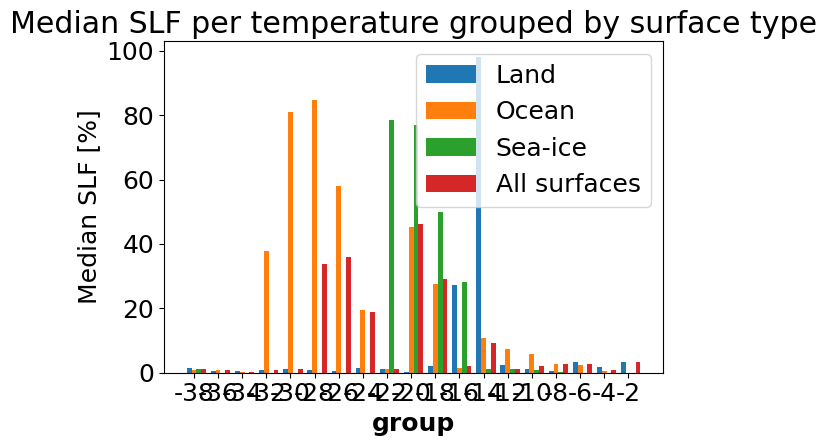

In [29]:
# Barplot 
# bar graph with 4 bars showing the mean SLF for each temperature interval (one for each surface type + overall). 

# define data
labels = surf_stat_dict['sea-ice'].temp_cat
land = surf_stat_dict['land-main'].SLF
ocean = surf_stat_dict['sea-ocean'].SLF
sea_ice = surf_stat_dict['sea-ice'].SLF
all = surf_stat_dict['All surfaces'].SLF

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Set position of bar on X axis
r1 = np.arange(len(land))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]

fig, ax = plt.subplots()
rects1 = ax.bar(r1, land, width, label='Land')
rects2 = ax.bar(r2, ocean, width, label='Ocean')
rects3 = ax.bar(r3, sea_ice, width, label='Sea-ice')
rects4 = ax.bar(r4, all, width, label='All surfaces')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median SLF [%]')
ax.set_title('Median SLF per temperature grouped by surface type')
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + width for r in range(len(land))], labels)

ax.legend()

fig.tight_layout()
plt.savefig('SLF_surface_barplot2.png')
plt.show()


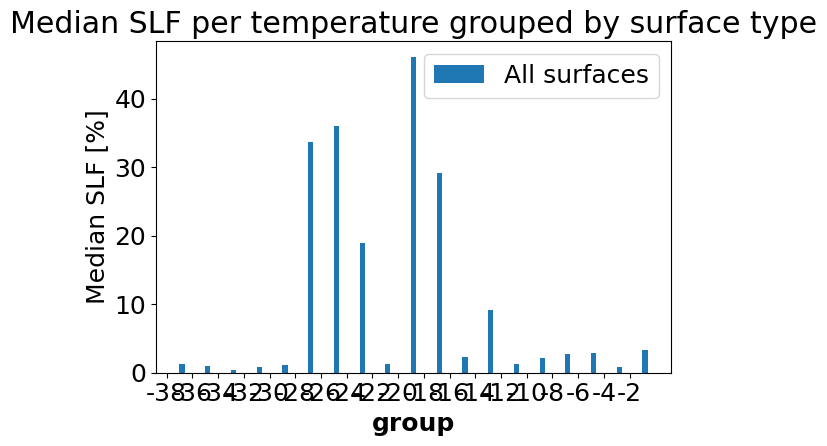

In [34]:
# Barplot 
# bar graph with 4 bars showing the mean SLF for each temperature interval (one for each surface type + overall). 

# define data
labels = surf_stat_dict['All surfaces'].temp_cat
all = surf_stat_dict['All surfaces'].SLF

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects4 = ax.bar(r4, all, width, label='All surfaces')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median SLF [%]')
ax.set_title('Median SLF per temperature grouped by surface type')
# Add xticks on the middle of the group bars
plt.xlabel('temp cat', fontweight='bold')
plt.xticks(np.arange(len(labels)), labels)

ax.legend()

fig.tight_layout()
#plt.savefig('SLF_surface_barplot2.png')
plt.show()


In [36]:
rects4[0]